In [1]:
from abc import ABC, abstractmethod
from dataclasses import dataclass
import time
import tqdm
from tqdm import trange
from typing import Callable, Dict, Optional, Tuple, Union

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import ot
import pandas as pd
import torch
from torch import Tensor
from torch.distributions import Normal  # noqa: F401
from torch.distributions import Categorical
from torch.distributions import Distribution as torchDist

from ex2mcmc import gan_distribution
from ex2mcmc.metrics.total_variation import average_total_variation
from ex2mcmc.metrics.chain import ESS, acl_spectrum, autocovariance

2024-01-21 00:45:56.281707: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-21 00:45:56.281749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-21 00:45:56.282821: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-21 00:45:57.170385: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
class Distribution(ABC):
    """Abstract class for distribution"""

    @abstractmethod
    def log_prob(self, z: torch.Tensor) -> torch.Tensor:
        """Computes log probability of input z"""
        raise NotImplementedError


class SamplableDistribution(Distribution):

    @abstractmethod
    def sample(self, sample_count) -> Tensor:
        pass


class GaussianMixture(SamplableDistribution):
    def __init__(self, means, covs, weights):
        self.weights = Tensor(weights)
        self.category = torch.distributions.Categorical(self.weights)
        self.means = means
        self.covs = covs

    def sample(self, sample_count: int) -> Tensor:
        which_gaussian = self.category.sample((sample_count,))
        multivariate_normal = torch.distributions.MultivariateNormal(
            self.means[which_gaussian], self.covs[which_gaussian])
        
        return Tensor(multivariate_normal.sample())
    
    def log_prob(self, z: Tensor) -> Tensor:
        logs = torch.distributions.MultivariateNormal(self.means, self.covs).log_prob(z[:, None, :])
        return Tensor(torch.log(torch.exp(logs) @ self.weights))

In [4]:
def compute_metrics(
    xs_true,
    xs_pred,
    name=None,
    sample_count=1000,
    scale=1.0,
    trunc_chain_len: int = 0,
    ess_rar=1,
):
    metrics = dict()
    key = jax.random.PRNGKey(0)
    n_steps = 25
    # sample_count = 100

    ess = ESS(
        acl_spectrum(
            xs_pred[::ess_rar] - xs_pred[::ess_rar].mean(0)[None, ...],
        ),
    ).mean()
    metrics["ess"] = ess

    xs_pred = xs_pred[-trunc_chain_len:]
    
    #print("avg total variation")
    tracker = average_total_variation(
        key,
        xs_true,
        xs_pred,
        n_steps=n_steps,
        sample_count=sample_count,
    )

    metrics["tv_mean"] = tracker.mean()
    metrics["tv_conf_sigma"] = tracker.std_of_mean()

    mean = tracker.mean()
    std = tracker.std()

    metrics["wasserstein"] = 0
    #Cost_matr_isir = ot.dist(x1 = isir_res[j][i], x2=gt_samples[i], metric='sqeuclidean', p=2, w=None)
    #print("wasserstein")
    for b in range(xs_pred.shape[1]):
        M = np.array(ot.dist(xs_true / scale, xs_pred[:, b] / scale))
        emd = ot.lp.emd2([], [], M, numItermax=1e6)
        metrics["wasserstein"] += emd / xs_pred.shape[1]

    return metrics

In [5]:
def heuristics_step_size(
    mean_acceptance: float,
    target_acceptance: float,
    step_size: float,
    factor: float = 1.05,
    tol: float = 0.03,
):
    if mean_acceptance - target_acceptance > tol:
        return step_size * factor
    if target_acceptance - mean_acceptance > tol:
        return step_size / factor
    return step_size

def mala(
    starting_points: torch.Tensor,
    target_dist: Union[SamplableDistribution, torchDist],
    sample_count: int,
    burn_in: int,
    project: Callable = lambda x: x,
    *,
    step_size: float = 1,
    verbose: bool = False,
    target_acceptance=None,
    meta: Optional[Dict] = None,
    keep_graph: bool = False,
) -> Tuple[torch.Tensor, Dict]:
    """
    Metropolis-Adjusted Langevin Algorithm with Normal proposal_dist

    Args:
        starting_points - strating points of shape [n_chains x dim]
        target_dist - target_dist distribution instance with method "log_prob"
        step_size - step size for drift term
        verbose - whether show iterations' bar

    Returns:
        sequence of slices per each iteration, meta
    """
    if sample_count + burn_in <= 0:
        raise ValueError("Number of steps might be positive")

    chains = []
    point = starting_points.clone()
    point.requires_grad_()
    point.grad = None

    device = point.device

    # Reassigning of the argument proposal_dist
    proposal_dist = torch.distributions.MultivariateNormal(
        torch.zeros(point.shape[-1], device=device),
        torch.eye(point.shape[-1], device=device),
    )

    meta = meta or dict()
    meta["mh_accept"] = meta.get("mh_accept", [])
    meta["step_size"] = meta.get("step_size", [])
    meta["logp"] = logp_x = target_dist.log_prob(point)

    if "grad" not in meta:
        if keep_graph:
            grad_x = torch.autograd.grad(
                meta["logp"].sum(),
                point,
                create_graph=keep_graph,
                retain_graph=keep_graph,
            )[0]
        else:
            grad_x = torch.autograd.grad(logp_x.sum(), point)[0].detach()
        meta["grad"] = grad_x
    else:
        grad_x = meta["grad"]

    pbar = trange if verbose else range
    for step_id in pbar(sample_count + burn_in):
        noise = proposal_dist.sample(point.shape[:-1])
        proposal_point = point + step_size * grad_x + noise * (2 * step_size) ** 0.5
        proposal_point = project(proposal_point)
        if not keep_graph:
            proposal_point = proposal_point.detach().requires_grad_()

        logp_y = target_dist.log_prob(proposal_point)
        grad_y = torch.autograd.grad(
            logp_y.sum(),
            proposal_point,
            create_graph=keep_graph,
            retain_graph=keep_graph,
        )[
            0
        ]  # .detach()

        log_qyx = proposal_dist.log_prob(noise)
        log_qxy = proposal_dist.log_prob(
            (point - proposal_point - step_size * grad_y) / (2 * step_size) ** 0.5
        )

        accept_prob = torch.clamp((logp_y + log_qxy - logp_x - log_qyx).exp(), max=1)
        mask = torch.rand_like(accept_prob) < accept_prob
        mask = mask.detach()

        if keep_graph:
            mask_f = mask.float()
            point = point * (1 - mask_f) + proposal_point * mask_f
            logp_x = logp_x * (1 - mask_f) + logp_y * mask_f
            grad_x = grad_x * (1 - mask_f) + grad_y * mask_f
        else:
            with torch.no_grad():
                point[mask] = proposal_point[mask]
                logp_x[mask] = logp_y[mask]
                grad_x[mask] = grad_y[mask]

        meta["mh_accept"].append(mask.float().mean().item())
        if target_acceptance:
            step_size = heuristics_step_size(
                meta["mh_accept"][-1], target_acceptance, step_size
            )
        meta["step_size"].append(step_size)

        if not keep_graph:
            point = point.detach().requires_grad_()
        if step_id >= burn_in:
            chains.append(point.cpu().clone())
    chains = torch.stack(chains, 0)

    meta["logp"] = logp_x
    meta["grad"] = grad_x
    meta["mask"] = mask.detach().cpu()

    return chains, meta

In [6]:
def ada_mala(
    starting_points: torch.Tensor,
    target_dist: Union[SamplableDistribution, torchDist],
    sample_count: int,
    burn_in: int,
    project: Callable = lambda x: x,
    *,
    sigma: float = 1,
    rho: float = 0.015,
    alpha: float = 0.574,
    verbose: bool = False,
    meta: Optional[Dict] = None,
    keep_graph: bool = False,
) -> Tuple[torch.Tensor, Dict]:
    if sample_count + burn_in <= 0:
        raise ValueError("Number of steps might be positive")

    chains = []
    point = starting_points.clone()
    point.requires_grad_()
    point.grad = None
    sigma = 1

    device = point.device

    # Reassigning of the argument proposal_dist
    proposal_dist = torch.distributions.MultivariateNormal(
        torch.zeros(point.shape[-1], device=device),
        torch.eye(point.shape[-1], device=device),
    )

    meta = meta or dict()
    meta["mh_accept"] = meta.get("mh_accept", [])
    meta["step_size"] = meta.get("step_size", [])
    meta["logp"] = logp_x = target_dist.log_prob(point)
    meta["sigma"] = meta.get("sigma", [])

    if "grad" not in meta:
        if keep_graph:
            grad_x = torch.autograd.grad(
                meta["logp"].sum(),
                point,
                create_graph=keep_graph,
                retain_graph=keep_graph,
            )[0]
        else:
            grad_x = torch.autograd.grad(logp_x.sum(), point)[0].detach()
        meta["grad"] = grad_x
    else:
        grad_x = meta["grad"]

    pbar = trange if verbose else range
    for step_id in pbar(sample_count + burn_in):
        noise = proposal_dist.sample(point.shape[:-1])

        proposal_point = point + sigma ** 2 * grad_x + noise * sigma 
        
        if not keep_graph:
            proposal_point = proposal_point.detach().requires_grad_()

        logp_y = target_dist.log_prob(proposal_point)
        grad_y = torch.autograd.grad(
            logp_y.sum(),
            proposal_point,
            create_graph=keep_graph,
            retain_graph=keep_graph,
        )[
            0
        ]  # .detach()

        log_qyx = proposal_dist.log_prob(noise)
        log_qxy = proposal_dist.log_prob(
            (point - proposal_point - sigma ** 2 * grad_y) / sigma
        )

        accept_prob = torch.clamp((logp_y + log_qxy - logp_x - log_qyx).exp(), max=1)
        mask = torch.rand_like(accept_prob) < accept_prob
        mask = mask.detach()

        if keep_graph:
            mask_f = mask.float()
            point = point * (1 - mask_f) + proposal_point * mask_f
            logp_x = logp_x * (1 - mask_f) + logp_y * mask_f
            grad_x = grad_x * (1 - mask_f) + grad_y * mask_f
        else:
            with torch.no_grad():
                point[mask] = proposal_point[mask]
                logp_x[mask] = logp_y[mask]
                grad_x[mask] = grad_y[mask]

        last_accept = mask.float().mean().item()
        meta["mh_accept"].append(last_accept)

        sigma *= (1 + rho * (last_accept - alpha))
        meta["sigma"].append(sigma)

        if not keep_graph:
            point = point.detach().requires_grad_()
        if step_id >= burn_in:
            chains.append(point.cpu().clone())
    chains = torch.stack(chains, 0)

    meta["logp"] = logp_x
    meta["grad"] = grad_x
    meta["mask"] = mask.cpu()

    return chains, meta

In [7]:
@dataclass
class BenchmarkUtils:

    @staticmethod
    def generate_starting_points(chain_count: int, dimension: int,
                                 mass_points: Tensor, distance: float) -> Tensor:
        starting_points = Tensor(chain_count, dimension).uniform_(-1, 1)
        starting_points /= torch.norm(starting_points, dim=1).reshape(-1, 1)
    
        length = Tensor(chain_count).uniform_(0, distance).reshape(-1, 1)
        return mass_points[torch.randint(0, len(mass_points), (chain_count,))] + \
                           starting_points * length

    @staticmethod
    def sample_mcmc(sampling_algorithm: Callable, starting_points: Tensor,
                    target_dist: Distribution, sample_count: int, **kwargs) -> Tensor:
        return sampling_algorithm(starting_points=starting_points, 
                                  target_dist=target_dist,
                                  sample_count=sample_count, **kwargs)
    
    @staticmethod
    def plot_samples(ax: plt.Axes, samples: Tensor,
                     title: Union[None, str] = None) -> None:
        ax.scatter(samples[:, 0], samples[:, 1])
        if title is not None:
            ax.set_title(title)

    @staticmethod
    def create_plot(mcmc_samples: Tensor, true_samples: Union[None, Tensor] = None,
                    target_title: Union[None, str] = None, fig_side: int = 5):
        
        chain_count = mcmc_samples.shape[1]
        mcmc_first_ax = 0

        if true_samples is not None:
            fig, axes = plt.subplots(nrows=chain_count+1, ncols=1,
                                     figsize=(fig_side, fig_side*(chain_count+1)))
            BenchmarkUtils.plot_samples(axes[0], true_samples, target_title)
            mcmc_first_ax = 1
        else:
            fig, axes = plt.subplots(nrows=chain_count, n_cols=1,
                                     figsize=(fig_side, fig_side*chain_count))
            
        for chain_index, ax in enumerate(axes[mcmc_first_ax:]):
            BenchmarkUtils.plot_samples(ax, mcmc_samples[:, chain_index],
                                        f"chain_{chain_index+1}")          

    @staticmethod
    def compute_metrics(mcmc_samples: Tensor, true_samples: Tensor, 
                        **kwargs) -> dict:
        return compute_metrics(jnp.array(true_samples),
                               jnp.array(mcmc_samples), **kwargs)

In [8]:
torch.rand((4, 4)) * 10 - 5

tensor([[-2.0389,  0.1656, -2.4833,  1.8856],
        [-4.2603,  3.6652, -3.6342, -3.9752],
        [-3.1594,  2.2645, -1.8475,  1.8711],
        [-4.2436, -3.0336, -1.8359, -0.9826]])

In [9]:
torch.full((10,), 1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
# Dummy example

torch.manual_seed(seed)
np.random.seed(seed)

mass_points_count = 10
true_means = torch.rand((mass_points_count, mass_points_count)) * 10 - 5
true_covs = torch.eye(mass_points_count).repeat(mass_points_count, 1, 1)

sample_count = 1000
gm = GaussianMixture(true_means, true_covs,
                     torch.full((mass_points_count,), 1/mass_points_count))

starting_points = true_means
target_dist = gm

true_samples = gm.sample(sample_count)

mcmc_samples = BenchmarkUtils.sample_mcmc(mala, starting_points, target_dist,
                                          sample_count=sample_count,
                                          burn_in=1000,
                                          step_size=0.5, keep_graph=False)[0].detach()

# BenchmarkUtils.create_plot(mcmc_samples, true_samples, "true dist")
BenchmarkUtils.compute_metrics(mcmc_samples, true_samples)

{'ess': 0.16828528,
 'tv_mean': Array(0.5395099, dtype=float32),
 'tv_conf_sigma': Array(0.00885558, dtype=float32),
 'wasserstein': 128.45395110931392}

{'ess': 0.11968595,
 'tv_mean': Array(0.5386935, dtype=float32),
 'tv_conf_sigma': Array(0.00922935, dtype=float32),
 'wasserstein': 130.7138140106201}

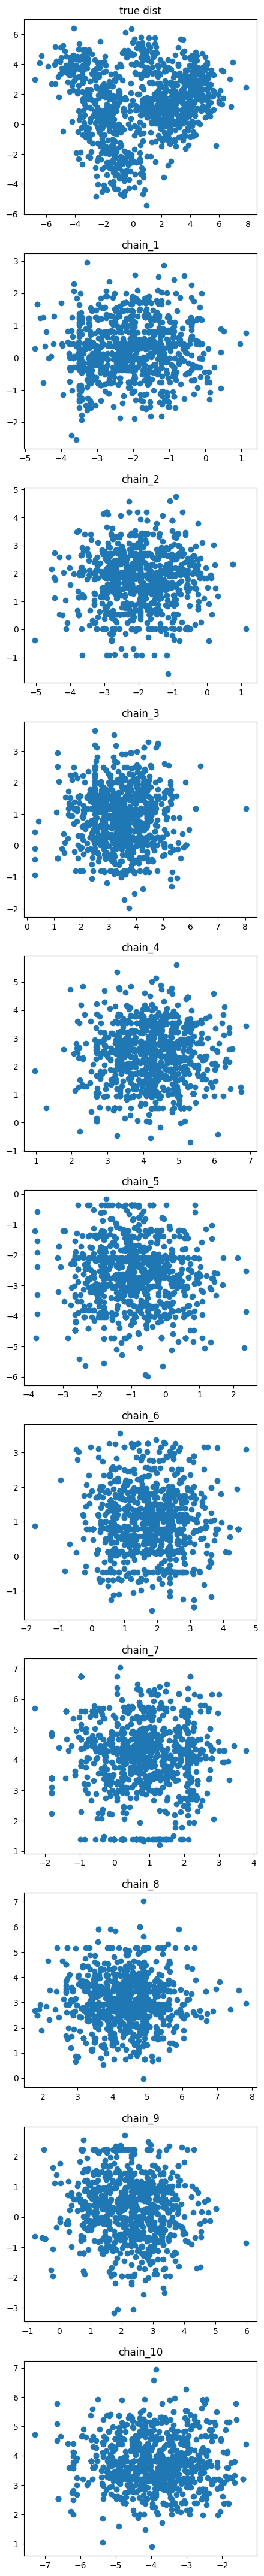

In [11]:
mcmc_samples = BenchmarkUtils.sample_mcmc(ada_mala, starting_points, target_dist,
                                          sample_count=sample_count,
                                          burn_in=1000,
                                          keep_graph=True)[0].detach()

BenchmarkUtils.create_plot(mcmc_samples, true_samples, "true dist")
BenchmarkUtils.compute_metrics(mcmc_samples, true_samples)

In [12]:
# np.mean(mcmc_samples[1]["mh_accept"])

In [13]:
x = torch.Tensor([[10, 10, 10], [1, 1, 1]])

In [14]:
@dataclass
class Benchmark:
    target_dist: SamplableDistribution
    target_dist_mass_points: Tensor
    target_dist_title: str
    dimension: int
    sampling_algorithm: Callable
    sample_count: int
    chain_count: int
    distance_to_mass_points: float
    

    def run(self, plot=False, **kwargs) -> dict:
        start_time = time.perf_counter()

        starting_points = BenchmarkUtils.generate_starting_points(
            self.chain_count, self.dimension,
            self.target_dist_mass_points,
            self.distance_to_mass_points
        )
        
        true_samples = self.target_dist.sample(sample_count)

        mcmc_samples = BenchmarkUtils.sample_mcmc(
            self.sampling_algorithm, starting_points, self.target_dist,
            sample_count=self.sample_count, **kwargs)[0].detach()

        if plot:
            BenchmarkUtils.create_plot(mcmc_samples, true_samples, "true dist")
            
        res_metrics = BenchmarkUtils.compute_metrics(mcmc_samples, true_samples)
        time_elapsed = time.perf_counter() - start_time
        res_metrics["time_elapsed"] = time_elapsed

        return res_metrics

In [16]:
algs = [mala, ada_mala]
res_total = {
    alg.__name__: {}
    for alg in algs
}
distances = [0.01, 0.1, 1, 2, 8]

for distance in tqdm.tqdm(distances):
    for alg in algs:
        benchmark = Benchmark(
            target_dist=gm,
            target_dist_title="true samples 0.5 $\mathcal{N}(0, I) + 0.5\mathcal{N}((10, 10), I)$",
            dimension=mass_points_count,
            sampling_algorithm=alg, 
            sample_count=sample_count,
            chain_count=100,
            target_dist_mass_points=true_means,
            distance_to_mass_points=distance
        )

        cur_res = benchmark.run(burn_in=1000,
                                keep_graph=False)
        cur_res["distance"] = distance
        
        for key in cur_res:
            if key in res_total[alg.__name__]:
                res_total[alg.__name__][key].append(cur_res[key])
            else:
                res_total[alg.__name__][key] = [cur_res[key]]

100%|██████████| 5/5 [10:50<00:00, 130.17s/it]


In [17]:
pd.DataFrame(res_total["mala"])

,ess,tv_mean,tv_conf_sigma,wasserstein,time_elapsed,distance
0,0.119183,0.54190606,0.0029263997,133.781865,73.606120,0.01
1,0.120030,0.54394495,0.0029809251,135.831892,65.223181,0.10
2,0.115880,0.54527843,0.0029976056,134.477163,63.924031,1.00
3,0.117271,0.5372903,0.0028528732,130.542747,63.532707,2.00
4,0.118551,0.53568405,0.0029629653,129.235010,63.936055,8.00


In [18]:
pd.DataFrame(res_total["ada_mala"])

,ess,tv_mean,tv_conf_sigma,wasserstein,time_elapsed,distance
0,0.369252,0.5427237,0.0030794146,133.292771,65.464067,0.01
1,0.368539,0.5452579,0.0029546774,135.505766,64.414055,0.10
2,0.367486,0.5376485,0.0029698613,132.747174,63.643655,1.00
3,0.366150,0.5376504,0.0029413807,128.226056,63.427124,2.00
4,0.370094,0.54101044,0.0030223026,132.673220,63.689434,8.00
